In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip uninstall -y nltk
!pip install --upgrade nltk
!pip install emoji

Found existing installation: nltk 3.9.1
Uninstalling nltk-3.9.1:
  Successfully uninstalled nltk-3.9.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 11.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from transformers import AutoConfig, AutoModel, AutoTokenizer, AdamW
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import emoji

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
root = '/content/drive/MyDrive/NLP/Challenge_2024/irony/'
with open(root+"train_text.txt") as f_input:
    data = [line for line in f_input]

texts = pd.DataFrame(data, columns=['text'])
texts

,text
0,seeing ppl walking w/ crutches makes me really...
1,"look for the girl with the broken smile, ask h..."
2,Now I remember why I buy books online @user #s...
3,@user @user So is he banded from wearing the c...
4,Just found out there are Etch A Sketch apps. ...
...,...
2857,I don't have to respect your beliefs.||I only ...
2858,Women getting hit on by married managers at @u...
2859,@user no but i followed you and i saw you post...
2860,@user I dont know what it is but I'm in love y...


In [ ]:
labels = pd.read_csv(root+"train_labels.txt", header=None)
labels

,0
0,1
1,0
2,1
3,1
4,1
...,...
2857,0
2858,1
2859,0
2860,0


In [ ]:
data = pd.concat([texts, labels], axis=1)
data.columns = ['text', 'label']

In [ ]:
data['emoji_count'] = data['text'].apply(lambda text: sum(char in emoji.EMOJI_DATA.keys() for char in text))

In [ ]:
emojidf = (texts['text'].apply(lambda text: [token.chars for token in emoji.analyze(text, join_emoji=True)
                       if isinstance(token.value, emoji.EmojiMatch)]).explode().value_counts()
                      .rename_axis('Smiley').rename('Count').reset_index())
emoji_ironic = (data[data['label'] == 1]['text'].apply(lambda text: [token.chars for token in emoji.analyze(text, join_emoji=True)
                       if isinstance(token.value, emoji.EmojiMatch)]).explode().value_counts()
                      .rename_axis('Smiley').rename('Count').reset_index())

In [ ]:
emojidf_comparison = emojidf.merge(emoji_ironic, on='Smiley', how='outer', suffixes=('total', 'ironic')).fillna(0)
emojidf_comparison['ironic_ratio'] = emojidf_comparison['Countironic'] / emojidf_comparison['Counttotal']
emojidf_comparison = emojidf_comparison.sort_values(by='ironic_ratio', ascending=False)

In [ ]:
emojidf_comparison = emojidf_comparison[emojidf_comparison['Counttotal']>3]
emojidf_comparison

,Smiley,Counttotal,Countironic,ironic_ratio
99,😑,9,8.0,0.888889
100,😒,25,22.0,0.880000
126,😷,8,7.0,0.875000
83,🔫,5,4.0,0.800000
49,👎,5,4.0,0.800000
121,😱,5,4.0,0.800000
123,😳,8,6.0,0.750000
59,💃,4,3.0,0.750000
93,😊,7,5.0,0.714286
131,🙈,14,9.0,0.642857


In [ ]:
relevant_emojis = emojidf_comparison[emojidf_comparison['Counttotal']>3]

emoji_ironic_pool = relevant_emojis[relevant_emojis['ironic_ratio']>0.6]
print(emoji_ironic_pool)
emoji_ironic_pool = emoji_ironic_pool['Smiley'].tolist()
print(emoji_ironic_pool)
print("-----------")
emoji_non_ironic_pool = relevant_emojis[relevant_emojis['ironic_ratio']<0.4]
print(emoji_non_ironic_pool)
emoji_non_ironic_pool = emoji_non_ironic_pool['Smiley'].tolist()
print(emoji_non_ironic_pool)

    Smiley  Counttotal  Countironic  ironic_ratio
99       😑           9          8.0      0.888889
100      😒          25         22.0      0.880000
126      😷           8          7.0      0.875000
83       🔫           5          4.0      0.800000
49       👎           5          4.0      0.800000
121      😱           5          4.0      0.800000
123      😳           8          6.0      0.750000
59       💃           4          3.0      0.750000
93       😊           7          5.0      0.714286
131      🙈          14          9.0      0.642857
['😑', '😒', '😷', '🔫', '👎', '😱', '😳', '💃', '😊', '🙈']
-----------
    Smiley  Counttotal  Countironic  ironic_ratio
106      😜           6          2.0      0.333333
113      😣           6          2.0      0.333333
124      😴           6          2.0      0.333333
30       🎉           6          2.0      0.333333
111      😡          13          4.0      0.307692
29       🎅           7          2.0      0.285714
92       😉           4          1.0  

In [ ]:
data["has_ironic_emoji"] = data["text"].apply(lambda x: 1 if any(char in emoji_ironic_pool for char in x) else 0)
data["has_non_ironic_emoji"] = data["text"].apply(lambda x: 1 if any(char in emoji_non_ironic_pool for char in x) else 0)

In [ ]:
data

,text,label,emoji_count,has_ironic_emoji,has_non_ironic_emoji
0,seeing ppl walking w/ crutches makes me really...,1,0,0,0
1,"look for the girl with the broken smile, ask h...",0,2,0,1
2,Now I remember why I buy books online @user #s...,1,0,0,0
3,@user @user So is he banded from wearing the c...,1,0,0,0
4,Just found out there are Etch A Sketch apps. ...,1,0,0,0
...,...,...,...,...,...
2857,I don't have to respect your beliefs.||I only ...,0,0,0,0
2858,Women getting hit on by married managers at @u...,1,0,0,0
2859,@user no but i followed you and i saw you post...,0,0,0,0
2860,@user I dont know what it is but I'm in love y...,0,3,0,0


In [ ]:
data['text'] = data['text'].apply(lambda text: emoji.demojize(text))

In [ ]:
# Verifica il tokenizzatore
text = "This is a test sentence."
tokens = word_tokenize(text)
print("Tokenized:", tokens)

# Verifica il POS tagging
tags = pos_tag(tokens)
print("POS Tags:", tags)


Tokenized: ['This', 'is', 'a', 'test', 'sentence', '.']
POS Tags: [('This', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('test', 'NN'), ('sentence', 'NN'), ('.', '.')]


In [ ]:
# Funzione per contare i PoS
def extract_pos_counts(text):
    tokens = word_tokenize(text)  # Tokenizza il testo
    tagged = pos_tag(tokens)  # Tagga le parole con NLTK
    pos_counts = {
        'JJ': 0,   # Aggettivi
        'VB': 0,   # Verbi base
        'NN': 0,   # Sostantivi singolari
        'RB': 0    # Avverbi
    }
    for _, tag in tagged:
        if tag.startswith('JJ'):  # Aggettivi
            pos_counts['JJ'] += 1
        elif tag.startswith('VB'):  # Verbi
            pos_counts['VB'] += 1
        elif tag.startswith('NN'):  # Sostantivi
            pos_counts['NN'] += 1
        elif tag.startswith('RB'):  # Avverbi
            pos_counts['RB'] += 1
    return pos_counts


In [ ]:
# Estrai i conteggi dei PoS e espandi in colonne
data['pos_counts'] = data['text'].apply(extract_pos_counts)
df_pos = data['pos_counts'].apply(pd.Series)  # Espandi il dizionario
data = pd.concat([data, df_pos], axis=1)  # Unisci al DataFrame originale

# Aggiungi la colonna delle etichette
data['label'] = labels

# Verifica la presenza delle colonne
print(data.columns)  # Assicurati che 'JJ', 'VB', 'NN', 'RB' e 'label' siano presenti

# Calcola la matrice di correlazione
correlation_matrix = data[['JJ', 'VB', 'NN', 'RB', 'label']].corr()
print(correlation_matrix)


Index(['text', 'label', 'emoji_count', 'has_ironic_emoji',
       'has_non_ironic_emoji', 'pos_counts', 'JJ', 'VB', 'NN', 'RB'],
      dtype='object')
             JJ        VB        NN        RB     label
JJ     1.000000  0.167529  0.111202  0.105756  0.012185
VB     0.167529  1.000000  0.209362  0.347041  0.028486
NN     0.111202  0.209362  1.000000 -0.005961 -0.133630
RB     0.105756  0.347041 -0.005961  1.000000 -0.001017
label  0.012185  0.028486 -0.133630 -0.001017  1.000000


In [ ]:
data

,text,label,emoji_count,has_ironic_emoji,has_non_ironic_emoji,pos_counts,JJ,VB,NN,RB
0,seeing ppl walking w/ crutches makes me really...,1,0,0,0,"{'JJ': 2, 'VB': 4, 'NN': 4, 'RB': 1}",2,4,4,1
1,"look for the girl with the broken smile, ask h...",0,2,0,1,"{'JJ': 0, 'VB': 5, 'NN': 6, 'RB': 0}",0,5,6,0
2,Now I remember why I buy books online @user #s...,1,0,0,0,"{'JJ': 0, 'VB': 3, 'NN': 3, 'RB': 2}",0,3,3,2
3,@user @user So is he banded from wearing the c...,1,0,0,0,"{'JJ': 0, 'VB': 4, 'NN': 6, 'RB': 0}",0,4,6,0
4,Just found out there are Etch A Sketch apps. ...,1,0,0,0,"{'JJ': 1, 'VB': 2, 'NN': 5, 'RB': 1}",1,2,5,1
...,...,...,...,...,...,...,...,...,...,...
2857,I don't have to respect your beliefs.||I only ...,0,0,0,0,"{'JJ': 2, 'VB': 6, 'NN': 3, 'RB': 2}",2,6,3,2
2858,Women getting hit on by married managers at @u...,1,0,0,0,"{'JJ': 1, 'VB': 2, 'NN': 7, 'RB': 0}",1,2,7,0
2859,@user no but i followed you and i saw you post...,0,0,0,0,"{'JJ': 2, 'VB': 7, 'NN': 4, 'RB': 0}",2,7,4,0
2860,@user I dont know what it is but I'm in love y...,0,3,0,0,"{'JJ': 2, 'VB': 5, 'NN': 8, 'RB': 0}",2,5,8,0


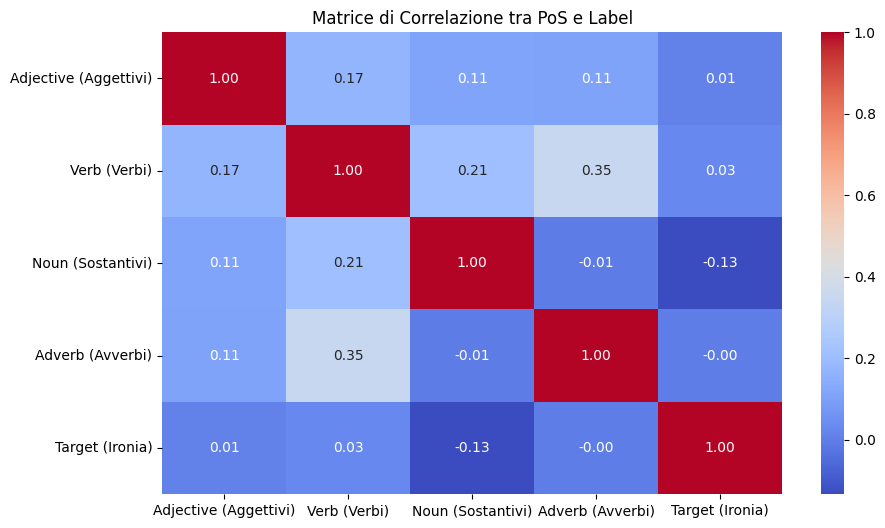

In [ ]:
# Espandi i risultati in colonne separate
df_pos = data['pos_counts'].apply(pd.Series)

# Evita i duplicati: Rimuovi le colonne esistenti prima di concatenare
df = data.drop(columns=['JJ', 'VB', 'NN', 'RB'], errors='ignore')  # Rimuove se esistono già
df = pd.concat([data, df_pos], axis=1)


# Calcolare la matrice di correlazione
correlation_matrix = data[['JJ', 'VB', 'NN', 'RB', 'label']].corr()

# Dizionario per spiegare le abbreviazioni
pos_labels = {
    'JJ': 'Adjective (Aggettivi)',
    'VB': 'Verb (Verbi)',
    'NN': 'Noun (Sostantivi)',
    'RB': 'Adverb (Avverbi)',
    'label': 'Target (Ironia)'
}

# Rinominare colonne e righe nella matrice di correlazione
correlation_matrix.rename(columns=pos_labels, index=pos_labels, inplace=True)

# Visualizzare la matrice di correlazione
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice di Correlazione tra PoS e Label")
plt.show()


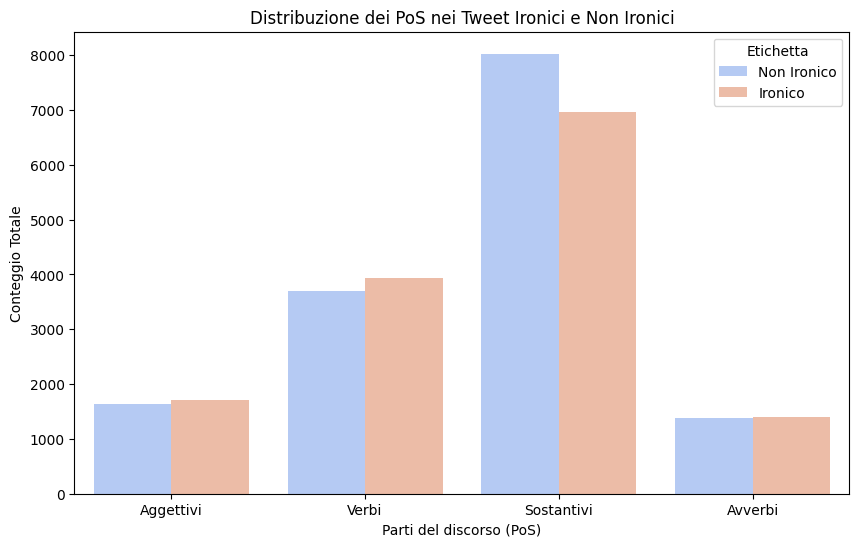

In [ ]:
# Calcolare la somma dei PoS per ciascuna classe (ironico e non ironico)
pos_summary = df.groupby('label')[['JJ', 'VB', 'NN', 'RB']].sum()

# Rinominare le etichette per chiarezza
pos_summary.index = ['Non Ironico', 'Ironico']

# Reset dell'indice e rinomina per il metodo melt
pos_summary = pos_summary.reset_index().rename(columns={'index': 'Etichetta'})

# Trasformare il DataFrame in formato "long" con melt
pos_summary_melted = pos_summary.melt(id_vars='Etichetta', var_name='PoS', value_name='Conteggio')

# Dizionario per la leggibilità delle etichette
pos_labels_graph = {
    'JJ': 'Aggettivi',
    'VB': 'Verbi',
    'NN': 'Sostantivi',
    'RB': 'Avverbi'
}
pos_summary_melted['PoS'] = pos_summary_melted['PoS'].map(pos_labels_graph)

# Creazione del grafico
plt.figure(figsize=(10, 6))
sns.barplot(x='PoS', y='Conteggio', hue='Etichetta', data=pos_summary_melted, palette='coolwarm')

# Aggiungere titolo e etichette
plt.title("Distribuzione dei PoS nei Tweet Ironici e Non Ironici")
plt.xlabel("Parti del discorso (PoS)")
plt.ylabel("Conteggio Totale")
plt.legend(title="Etichetta", loc='upper right')
plt.show()


In [ ]:
# Aggiungi la colonna dei conteggi di sostantivi (NN) direttamente al DataFrame
data['NN_count'] = df_pos['NN']  # Se 'NN' non esiste, questa linea genera NaN

# Sostituisci eventuali NaN con 0 (facoltativo, per sicurezza)
data['NN_count'] = data['NN_count'].fillna(0).astype(int)


# Rimuovere le colonne specificate
# data = data.drop(columns=['JJ', 'VB', 'NN', 'RB'], errors='ignore')

# Rimuovere la riga 'pos_counts' se presente
data = data[data.index != 'pos_counts']


In [ ]:
data

,text,label,emoji_count,has_ironic_emoji,has_non_ironic_emoji,pos_counts,NN_count
0,seeing ppl walking w/ crutches makes me really...,1,0,0,0,"{'JJ': 2, 'VB': 4, 'NN': 4, 'RB': 1}",4
1,"look for the girl with the broken smile, ask h...",0,2,0,1,"{'JJ': 0, 'VB': 5, 'NN': 6, 'RB': 0}",6
2,Now I remember why I buy books online @user #s...,1,0,0,0,"{'JJ': 0, 'VB': 3, 'NN': 3, 'RB': 2}",3
3,@user @user So is he banded from wearing the c...,1,0,0,0,"{'JJ': 0, 'VB': 4, 'NN': 6, 'RB': 0}",6
4,Just found out there are Etch A Sketch apps. ...,1,0,0,0,"{'JJ': 1, 'VB': 2, 'NN': 5, 'RB': 1}",5
...,...,...,...,...,...,...,...
2857,I don't have to respect your beliefs.||I only ...,0,0,0,0,"{'JJ': 2, 'VB': 6, 'NN': 3, 'RB': 2}",3
2858,Women getting hit on by married managers at @u...,1,0,0,0,"{'JJ': 1, 'VB': 2, 'NN': 7, 'RB': 0}",7
2859,@user no but i followed you and i saw you post...,0,0,0,0,"{'JJ': 2, 'VB': 7, 'NN': 4, 'RB': 0}",4
2860,@user I dont know what it is but I'm in love y...,0,3,0,0,"{'JJ': 2, 'VB': 5, 'NN': 8, 'RB': 0}",8


In [ ]:
data = data.drop(columns=['pos_counts'])
data

,text,label,emoji_count,has_ironic_emoji,has_non_ironic_emoji,NN_count
0,seeing ppl walking w/ crutches makes me really...,1,0,0,0,4
1,"look for the girl with the broken smile, ask h...",0,2,0,1,6
2,Now I remember why I buy books online @user #s...,1,0,0,0,3
3,@user @user So is he banded from wearing the c...,1,0,0,0,6
4,Just found out there are Etch A Sketch apps. ...,1,0,0,0,5
...,...,...,...,...,...,...
2857,I don't have to respect your beliefs.||I only ...,0,0,0,0,3
2858,Women getting hit on by married managers at @u...,1,0,0,0,7
2859,@user no but i followed you and i saw you post...,0,0,0,0,4
2860,@user I dont know what it is but I'm in love y...,0,3,0,0,8


In [ ]:
import re

# Estrai gli hashtag da ogni tweet
data['hashtags'] = data['text'].apply(lambda x: re.findall(r"#\w+", x.lower()))  # Usa lower() per uniformare gli hashtag

# Espandi gli hashtag in un formato esploso per l'analisi
hashtags_exploded = data.explode('hashtags').dropna(subset=['hashtags'])

# Conta gli hashtag nei tweet ironici e non ironici
hashtag_counts = (
    hashtags_exploded.groupby(['hashtags', 'label'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: 'count_non_ironic', 1: 'count_ironic'})
)

# Calcola il totale e la probabilità di ironia per ogni hashtag
hashtag_counts['count_total'] = hashtag_counts['count_non_ironic'] + hashtag_counts['count_ironic']
hashtag_counts['ironic_ratio'] = hashtag_counts['count_ironic'] / hashtag_counts['count_total']

# Ordina per probabilità di ironia (opzionale)
hashtag_counts = hashtag_counts.sort_values(by='ironic_ratio', ascending=False)

# Mostra i risultati
print(hashtag_counts)

# Filtra gli hashtag più significativi (opzionale)
significant_hashtags = hashtag_counts[hashtag_counts['count_total'] > 3]  # Ad esempio, solo quelli con >5 occorrenze
print(significant_hashtags)


label              count_non_ironic  count_ironic  count_total  ironic_ratio
hashtags                                                                    
#lifegoals                        0             2            2           1.0
#lies                             0             1            1           1.0
#liberalmentality                 0             1            1           1.0
#lgbt                             0             1            1           1.0
#lfc                              0             2            2           1.0
...                             ...           ...          ...           ...
#living                           1             0            1           0.0
#littlemeh                        1             0            1           0.0
#literacy                         1             0            1           0.0
#list                             1             0            1           0.0
#lookmamnohands                   1             0            1           0.0

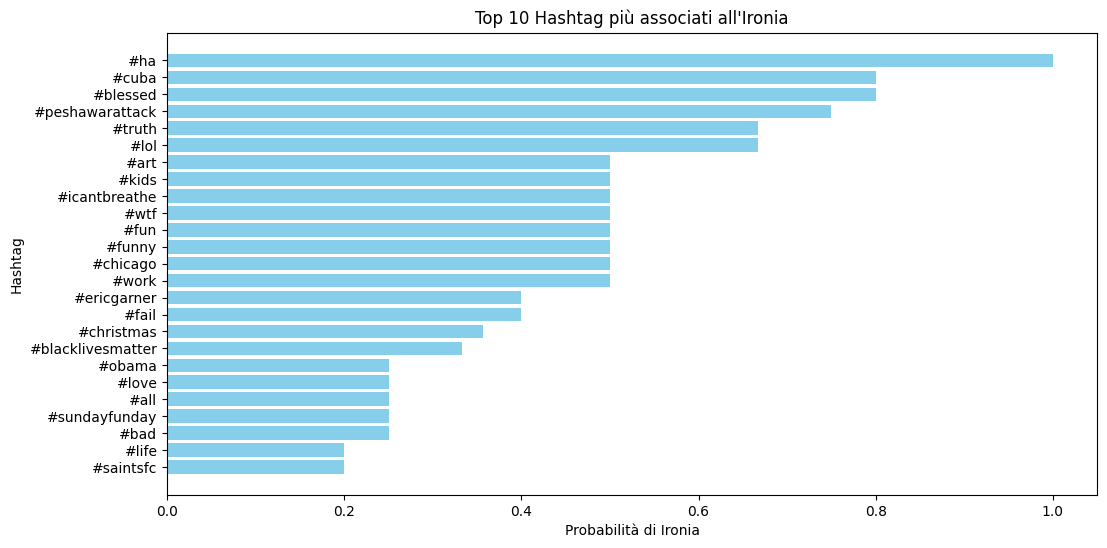

In [ ]:
import matplotlib.pyplot as plt

# Seleziona i primi 10 hashtag più "ironici" (opzionale)
top_ironic = significant_hashtags.nlargest(25, 'ironic_ratio')

# Grafico
plt.figure(figsize=(12, 6))
plt.barh(top_ironic.index, top_ironic['ironic_ratio'], color='skyblue')
plt.xlabel('Probabilità di Ironia')
plt.ylabel('Hashtag')
plt.title('Top 10 Hashtag più associati all\'Ironia')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
data['hashtag_count'] = data['hashtags'].apply(len)
data

,text,label,emoji_count,has_ironic_emoji,has_non_ironic_emoji,NN_count,hashtags,hashtag_count
0,seeing ppl walking w/ crutches makes me really...,1,0,0,0,4,[],0
1,"look for the girl with the broken smile, ask h...",0,2,0,1,6,[],0
2,Now I remember why I buy books online @user #s...,1,0,0,0,3,[#servicewithasmile],1
3,@user @user So is he banded from wearing the c...,1,0,0,0,6,[#karma],1
4,Just found out there are Etch A Sketch apps. ...,1,0,0,0,5,"[#oldschool, #notoldschool]",2
...,...,...,...,...,...,...,...,...
2857,I don't have to respect your beliefs.||I only ...,0,0,0,0,3,"[#atheist, #atheism]",2
2858,Women getting hit on by married managers at @u...,1,0,0,0,7,"[#hypocrites, #practicewhatyoupreach]",2
2859,@user no but i followed you and i saw you post...,0,0,0,0,4,[],0
2860,@user I dont know what it is but I'm in love y...,0,3,0,0,8,"[#love, #skincare, #beauty]",3


In [ ]:
data['has_ironic_hashtag'] = data['hashtags'].apply(
    lambda x: 1 if any(ht in significant_hashtags[significant_hashtags['ironic_ratio'] > 0.6].index for ht in x) else 0
)
data['has_non_ironic_hashtag'] = data['hashtags'].apply(
    lambda x: 1 if any(ht in significant_hashtags[significant_hashtags['ironic_ratio'] < 0.4].index for ht in x) else 0
)
data

,text,label,emoji_count,has_ironic_emoji,has_non_ironic_emoji,NN_count,hashtags,hashtag_count,has_ironic_hashtag,has_non_ironic_hashtag
0,seeing ppl walking w/ crutches makes me really...,1,0,0,0,4,[],0,0,0
1,"look for the girl with the broken smile, ask h...",0,2,0,1,6,[],0,0,0
2,Now I remember why I buy books online @user #s...,1,0,0,0,3,[#servicewithasmile],1,0,0
3,@user @user So is he banded from wearing the c...,1,0,0,0,6,[#karma],1,0,0
4,Just found out there are Etch A Sketch apps. ...,1,0,0,0,5,"[#oldschool, #notoldschool]",2,0,0
...,...,...,...,...,...,...,...,...,...,...
2857,I don't have to respect your beliefs.||I only ...,0,0,0,0,3,"[#atheist, #atheism]",2,0,0
2858,Women getting hit on by married managers at @u...,1,0,0,0,7,"[#hypocrites, #practicewhatyoupreach]",2,0,0
2859,@user no but i followed you and i saw you post...,0,0,0,0,4,[],0,0,0
2860,@user I dont know what it is but I'm in love y...,0,3,0,0,8,"[#love, #skincare, #beauty]",3,0,1


In [ ]:
def calculate_avg_ironic_ratio(hashtags):
    ratios = [hashtag_counts.loc[ht, 'ironic_ratio'] for ht in hashtags if ht in hashtag_counts.index]
    return np.mean(ratios) if ratios else 0

data['avg_ironic_ratio'] = data['hashtags'].apply(calculate_avg_ironic_ratio)
data

,text,label,emoji_count,has_ironic_emoji,has_non_ironic_emoji,NN_count,hashtags,hashtag_count,has_ironic_hashtag,has_non_ironic_hashtag,avg_ironic_ratio
0,seeing ppl walking w/ crutches makes me really...,1,0,0,0,4,[],0,0,0,0.000000
1,"look for the girl with the broken smile, ask h...",0,2,0,1,6,[],0,0,0,0.000000
2,Now I remember why I buy books online @user #s...,1,0,0,0,3,[#servicewithasmile],1,0,0,1.000000
3,@user @user So is he banded from wearing the c...,1,0,0,0,6,[#karma],1,0,0,1.000000
4,Just found out there are Etch A Sketch apps. ...,1,0,0,0,5,"[#oldschool, #notoldschool]",2,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2857,I don't have to respect your beliefs.||I only ...,0,0,0,0,3,"[#atheist, #atheism]",2,0,0,0.000000
2858,Women getting hit on by married managers at @u...,1,0,0,0,7,"[#hypocrites, #practicewhatyoupreach]",2,0,0,1.000000
2859,@user no but i followed you and i saw you post...,0,0,0,0,4,[],0,0,0,0.000000
2860,@user I dont know what it is but I'm in love y...,0,3,0,0,8,"[#love, #skincare, #beauty]",3,0,1,0.083333


In [ ]:
def count_specific_hashtags(hashtags, condition):
    return sum(1 for ht in hashtags if ht in hashtag_counts.index and condition(hashtag_counts.loc[ht, 'ironic_ratio']))

data['ironic_hashtag_count'] = data['hashtags'].apply(lambda x: count_specific_hashtags(x, lambda ratio: ratio > 0.6))
data['non_ironic_hashtag_count'] = data['hashtags'].apply(lambda x: count_specific_hashtags(x, lambda ratio: ratio < 0.4))

data['hashtag_diversity'] = data['hashtags'].apply(lambda x: len(set(x)) / len(x) if x else 0)
data['hashtag_irony_index'] = data['hashtags'].apply(
    lambda x: sum(hashtag_counts.loc[ht, 'ironic_ratio'] for ht in x if ht in hashtag_counts.index)
)
data

,text,label,emoji_count,has_ironic_emoji,has_non_ironic_emoji,NN_count,hashtags,hashtag_count,has_ironic_hashtag,has_non_ironic_hashtag,avg_ironic_ratio,ironic_hashtag_count,non_ironic_hashtag_count,hashtag_diversity,hashtag_irony_index
0,seeing ppl walking w/ crutches makes me really...,1,0,0,0,4,[],0,0,0,0.000000,0,0,0.0,0.00
1,"look for the girl with the broken smile, ask h...",0,2,0,1,6,[],0,0,0,0.000000,0,0,0.0,0.00
2,Now I remember why I buy books online @user #s...,1,0,0,0,3,[#servicewithasmile],1,0,0,1.000000,1,0,1.0,1.00
3,@user @user So is he banded from wearing the c...,1,0,0,0,6,[#karma],1,0,0,1.000000,1,0,1.0,1.00
4,Just found out there are Etch A Sketch apps. ...,1,0,0,0,5,"[#oldschool, #notoldschool]",2,0,0,1.000000,2,0,1.0,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,I don't have to respect your beliefs.||I only ...,0,0,0,0,3,"[#atheist, #atheism]",2,0,0,0.000000,0,2,1.0,0.00
2858,Women getting hit on by married managers at @u...,1,0,0,0,7,"[#hypocrites, #practicewhatyoupreach]",2,0,0,1.000000,2,0,1.0,2.00
2859,@user no but i followed you and i saw you post...,0,0,0,0,4,[],0,0,0,0.000000,0,0,0.0,0.00
2860,@user I dont know what it is but I'm in love y...,0,3,0,0,8,"[#love, #skincare, #beauty]",3,0,1,0.083333,0,3,1.0,0.25


In [ ]:
def classify_hashtag_position(text, hashtags):
    if not hashtags:
        return 'none'
    # Filtra gli hashtag presenti nel testo
    positions = [text.index(ht) for ht in hashtags if ht in text]
    if not positions:  # Se nessun hashtag è trovato nel testo
        return 'none'
    avg_pos = np.mean(positions) / len(text)
    return 'start' if avg_pos < 0.33 else 'end' if avg_pos > 0.66 else 'middle'

# Applica la funzione al DataFrame
data['hashtag_position'] = data.apply(lambda row: classify_hashtag_position(row['text'], row['hashtags']), axis=1)
data

,text,label,emoji_count,has_ironic_emoji,has_non_ironic_emoji,NN_count,hashtags,hashtag_count,has_ironic_hashtag,has_non_ironic_hashtag,avg_ironic_ratio,ironic_hashtag_count,non_ironic_hashtag_count,hashtag_diversity,hashtag_irony_index,hashtag_position
0,seeing ppl walking w/ crutches makes me really...,1,0,0,0,4,[],0,0,0,0.000000,0,0,0.0,0.00,none
1,"look for the girl with the broken smile, ask h...",0,2,0,1,6,[],0,0,0,0.000000,0,0,0.0,0.00,none
2,Now I remember why I buy books online @user #s...,1,0,0,0,3,[#servicewithasmile],1,0,0,1.000000,1,0,1.0,1.00,end
3,@user @user So is he banded from wearing the c...,1,0,0,0,6,[#karma],1,0,0,1.000000,1,0,1.0,1.00,none
4,Just found out there are Etch A Sketch apps. ...,1,0,0,0,5,"[#oldschool, #notoldschool]",2,0,0,1.000000,2,0,1.0,2.00,end
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,I don't have to respect your beliefs.||I only ...,0,0,0,0,3,"[#atheist, #atheism]",2,0,0,0.000000,0,2,1.0,0.00,end
2858,Women getting hit on by married managers at @u...,1,0,0,0,7,"[#hypocrites, #practicewhatyoupreach]",2,0,0,1.000000,2,0,1.0,2.00,end
2859,@user no but i followed you and i saw you post...,0,0,0,0,4,[],0,0,0,0.000000,0,0,0.0,0.00,none
2860,@user I dont know what it is but I'm in love y...,0,3,0,0,8,"[#love, #skincare, #beauty]",3,0,1,0.083333,0,3,1.0,0.25,middle


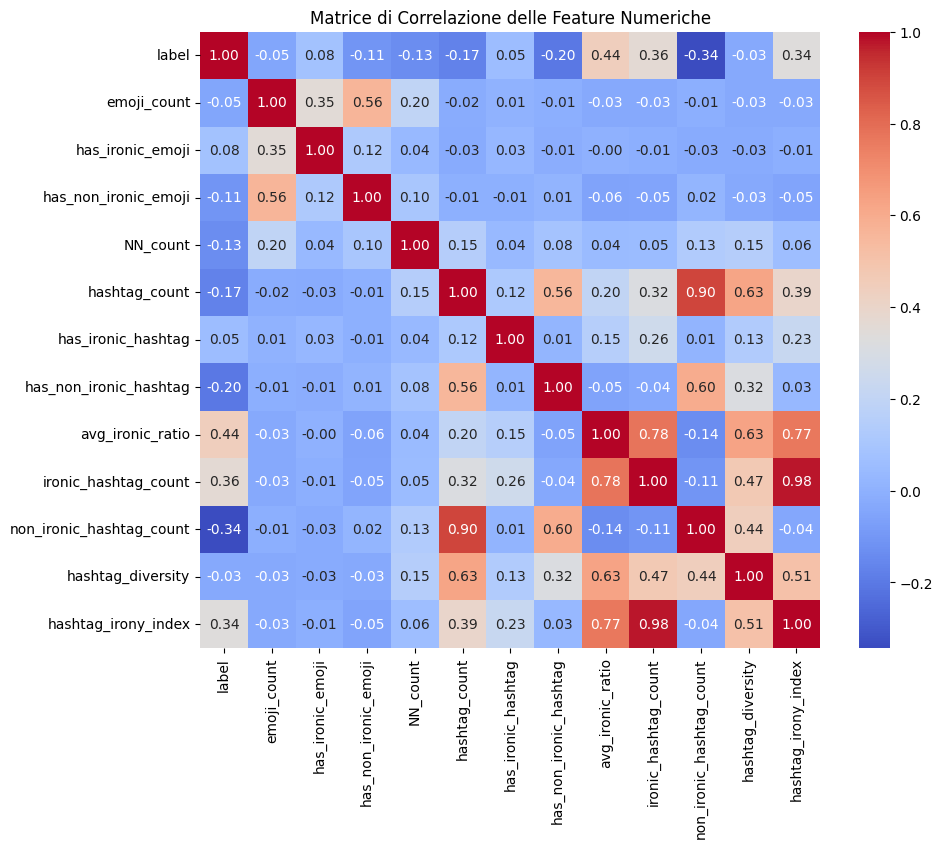

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supponendo che 'data' sia il tuo DataFrame

# Seleziona solo le colonne numeriche
numeric_data = data.select_dtypes(include=[np.number])

# Calcola la matrice di correlazione
correlation_matrix = numeric_data.corr()

# Visualizza la matrice di correlazione con una heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice di Correlazione delle Feature Numeriche')
plt.show()


In [ ]:
#random forest, c^2, c^2 con key best, grid search, feature selection, logistic regression e lasso
#max_depth = none, selekt key best con c^2, mutua informazione che calcola quanta discrepanza c'è fra le informazioni
# feature selection con rete neurale, per processare tutto quanto con Linear, relu e attivazione (obv)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(data.drop(columns=['label']), data['label'], test_size=0.4, random_state=42)

In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.8, random_state=42)

In [ ]:
x_train_2 = x_train.drop(columns=['text'])
x_train_2 = x_train_2.drop(columns=['hashtags'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
x_train_2['hashtag_position'] = le.fit_transform(x_train_2['hashtag_position'])
x_train_2

,emoji_count,has_ironic_emoji,has_non_ironic_emoji,NN_count,hashtag_count,has_ironic_hashtag,has_non_ironic_hashtag,avg_ironic_ratio,ironic_hashtag_count,non_ironic_hashtag_count,hashtag_diversity,hashtag_irony_index,hashtag_position
1278,0,0,0,1,0,0,0,0.0,0,0,0.0,0.0,2
888,0,0,0,3,0,0,0,0.0,0,0,0.0,0.0,2
2668,0,0,0,2,0,0,0,0.0,0,0,0.0,0.0,2
2686,0,0,0,7,1,0,0,1.0,1,0,1.0,1.0,2
2722,0,0,0,2,0,0,0,0.0,0,0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0,0,0,8,0,0,0,0.0,0,0,0.0,0.0,2
1095,0,0,0,8,1,0,0,0.0,0,1,1.0,0.0,2
1130,0,0,0,7,1,0,0,0.0,0,1,1.0,0.0,2
1294,0,0,0,8,0,0,0,0.0,0,0,0.0,0.0,2


In [ ]:
x_test_2 = x_test.drop(columns=['text'])
x_test_2 = x_test_2.drop(columns=['hashtags'])
x_test_2['hashtag_position'] = le.fit_transform(x_test_2['hashtag_position'])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators':[100, 150, 200],
    'criterion':('gini', 'entropy', 'log_loss'),
    'max_depth':[5, 10, 20, None]
}

forest = RandomForestClassifier(random_state=42)
grid = GridSearchCV(forest, parameters, scoring='accuracy') # mi serve per trovare le migliori combinazioni di iperparametri
grid.fit(x_train_2, y_train) # addestro la gridSearch

best_model = grid.best_estimator_
best_accuracy = grid.best_score_
best_params = grid.best_params_
print(f'Il miglior modello ha accuracy {best_accuracy} ed i suoi migliori parametri sono {best_params}')

Il miglior modello ha accuracy 0.7350345786154994 ed i suoi migliori parametri sono {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}


Accuracy: 0.7510917030567685


<Axes: >

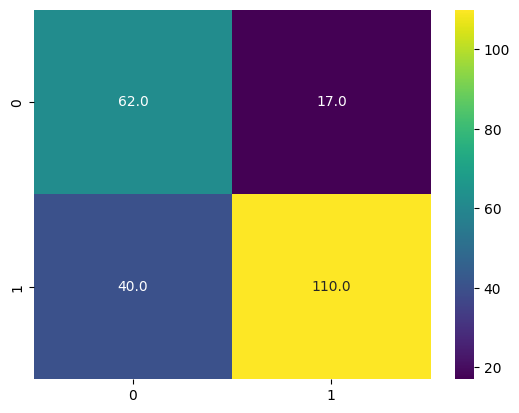

In [ ]:
# Testiamo l'accuracy del modello ottenuto
from sklearn.metrics import accuracy_score

y_pred = best_model.predict(x_test_2)
test_accuracy = accuracy_score(y_pred, y_test)
print(f'Accuracy: {test_accuracy}')

from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt = '.1f', cmap='viridis')

In [ ]:
from sklearn.feature_selection import SelectFromModel

sf = SelectFromModel(estimator=best_model)
sf.fit_transform(x_train_2, y_train)
print(sf.get_feature_names_out())

['hashtag_count' 'avg_ironic_ratio' 'ironic_hashtag_count'
 'non_ironic_hashtag_count' 'hashtag_irony_index']


In [ ]:
data2= data[sf.get_feature_names_out()]
data2['text'] = data['text']
data2['label'] = data['label']
data2

<ipython-input-89-0ad254552de4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['text'] = data['text']
<ipython-input-89-0ad254552de4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['label'] = data['label']


,hashtag_count,avg_ironic_ratio,ironic_hashtag_count,non_ironic_hashtag_count,hashtag_irony_index,text,label
0,0,0.000000,0,0,0.00,seeing ppl walking w/ crutches makes me really...,1
1,0,0.000000,0,0,0.00,"look for the girl with the broken smile, ask h...",0
2,1,1.000000,1,0,1.00,Now I remember why I buy books online @user #s...,1
3,1,1.000000,1,0,1.00,@user @user So is he banded from wearing the c...,1
4,2,1.000000,2,0,2.00,Just found out there are Etch A Sketch apps. ...,1
...,...,...,...,...,...,...,...
2857,2,0.000000,0,2,0.00,I don't have to respect your beliefs.||I only ...,0
2858,2,1.000000,2,0,2.00,Women getting hit on by married managers at @u...,1
2859,0,0.000000,0,0,0.00,@user no but i followed you and i saw you post...,0
2860,3,0.083333,0,3,0.25,@user I dont know what it is but I'm in love y...,0


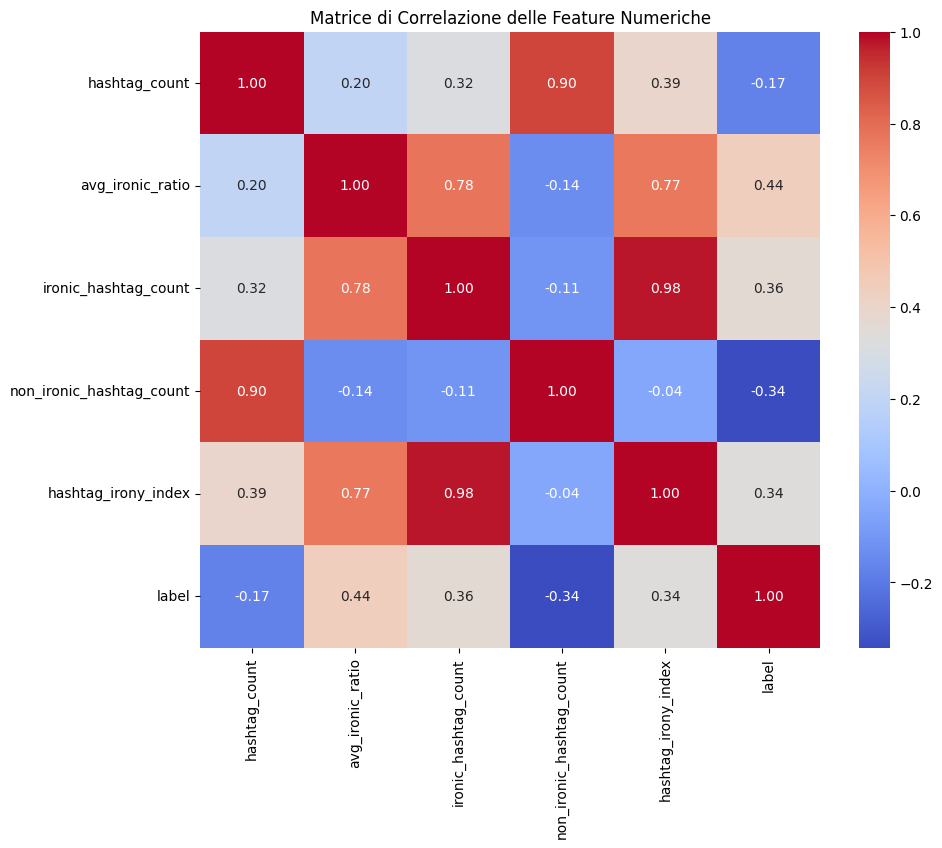

In [ ]:
numeric_data = data2.select_dtypes(include=[np.number])

# Calcola la matrice di correlazione
correlation_matrix = numeric_data.corr()

# Visualizza la matrice di correlazione con una heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice di Correlazione delle Feature Numeriche')
plt.show()

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(data2.drop(columns=['label']), data['label'], test_size=0.4, random_state=42)

In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.8, random_state=42)

In [ ]:
import pandas as pd

# Salva i dataframe in file CSV
x_train.to_csv('x_train.csv', index=False)
x_test.to_csv('x_test.csv', index=False)
x_val.to_csv('x_val.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
y_val.to_csv('y_val.csv', index=False)

In [ ]:
from google.colab import files

# Scarica i file
files.download('x_train.csv')
files.download('x_test.csv')
files.download('x_val.csv')
files.download('y_train.csv')
files.download('y_test.csv')
files.download('y_val.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>